Source: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb.

# Translate Korean to English

## Setup

In [1]:
# import libraries to work with strings
import os
import unicodedata
import string
import re
import random

In [2]:
# PyTorch modules
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

## Utilities

In [24]:
# useful tokens
SOS_token = 0
EOS_token = 1

In [22]:
# useful class to get the index for a word and get the word for an index
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        # n_words is the index of next new word
        self.n_words = 2 # Count SOS and EOS
    
    # no punctuation for these sentences
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    
    # 
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [155]:
# Turn a Unicode string to plain ASCII
# thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s, lang="en"):
    s = unicodeToAscii(s.strip().lstrip("#").lower())
    s = re.sub(r"([.!?]+)", r" .", s)
    if lang == "en":
        s = re.sub(r"[^a-z.]+", r" ", s)
    return s

In [20]:
# example
re.sub(r"([.!?])", r" \1WHOA", "hi eve?ry.one i wa.fff")

'hi eve ?WHOAry .WHOAone i wa .WHOAfff'

In [139]:
def read_file(filepath):
    pairs = []
    with open(filepath, "rb") as f:
        while True:
            line = f.readline()
            if line == b"":
                break
            if line.startswith(b"["):
                en_sentence = f.readline().decode("cp437")
                kr_sentence = f.readline().decode("cp949")
                pairs.append([normalizeString(en_sentence),
                              normalizeString(kr_sentence, lang="kr")])
    return pairs

In [73]:
import glob

In [84]:
!ls ../data/en2ko

cekcorpus00.txt


In [142]:
data_path = os.path.join("..", "data", "en2ko", "Corpus10")

In [143]:
glob.glob(data_path + "/*.txt")

['../data/en2ko/Corpus10/cekcorpus45-2.txt',
 '../data/en2ko/Corpus10/cekcorpus13.txt',
 '../data/en2ko/Corpus10/cekcorpus55-2.txt',
 '../data/en2ko/Corpus10/cekcorpus33-2.txt',
 '../data/en2ko/Corpus10/cekcorpus40-2.txt',
 '../data/en2ko/Corpus10/cekcorpus40-1.txt',
 '../data/en2ko/Corpus10/cekcorpus30-2.txt',
 '../data/en2ko/Corpus10/cekcorpus10.txt',
 '../data/en2ko/Corpus10/cekcorpus28-2.txt',
 '../data/en2ko/Corpus10/cekcorpus55-1.txt',
 '../data/en2ko/Corpus10/cekcorpus15-1.txt',
 '../data/en2ko/Corpus10/cekcorpus38.txt',
 '../data/en2ko/Corpus10/cekcorpus54-1.txt',
 '../data/en2ko/Corpus10/cekcorpus21.txt',
 '../data/en2ko/Corpus10/cekcorpus07.txt',
 '../data/en2ko/Corpus10/cekcorpus53.txt',
 '../data/en2ko/Corpus10/cekcorpus29-2.txt',
 '../data/en2ko/Corpus10/cekcorpus45-1.txt',
 '../data/en2ko/Corpus10/cekcorpus32-1.txt',
 '../data/en2ko/Corpus10/cekcorpus33-1.txt',
 '../data/en2ko/Corpus10/cekcorpus49-2.txt',
 '../data/en2ko/Corpus10/cekcorpus35-2.txt',
 '../data/en2ko/Corpus

In [140]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    #pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = []
    for filepath in glob.glob(data_path + "/*"):
        pairs += read_file(filepath)
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [100]:
file_to_unzip = os.path.join(data_path, "IggenPRIiUif6nF.zip")
!unzip -tq $file_to_unzip

warning [../data/en2ko/IggenPRIiUif6nF.zip]:  13 extra bytes at beginning or within zipfile
  (attempting to process anyway)
No errors detected in compressed data of ../data/en2ko/IggenPRIiUif6nF.zip.


In [156]:
input_lang, output_lang, pairs = readLangs("en", "ko", reverse=True)

Reading lines...


In [94]:
input_lang.name

'ko'

In [93]:
pairs[:10]

[['명령은 아래와 같이 반포되었다 .', 'the order went forth that .'],
 ['명령은 반드시 엄격히 준수해야 한다 .',
  'the orders must be strictly obeyed .'],
 ['운명의 여신은 용사를 특별히 애호하신다 .',
  'fortune favors the brave  .'],
 ['운명에 그가 죽을 것이라고 정해졌다 .',
  'fate destined that he shall die .'],
 ['운명에 그는 목사가 될 것이라고 정해졌다 .',
  'fate had ordained him to die young .'],
 ['우리가 이기는 것은 운명으로 정해졌다 .',
  'he was destined to enter the church .'],
 ['그가 교수형을 받는 것은 운명으로 정해졌다 .',
  'he is destined to the gallows .'],
 ['우리가 이기는 것은 운명으로 정해졌다 .',
  'it was preordained that we should win .'],
 ['만져보면 그것이 뜨거운지 알 수 있다 .', 'feel whether it is hot .'],
 ['내 찬 손을 좀 만져봐 .', 'feel my cold hands .']]

## Work with Korean

In [24]:
!ls ../data/ko2en

cekcorpus00.txt


In [15]:
with open("../data/ko2en/cekcorpus00.txt", "rb") as f:
    for i in range(6):
        a = f.readline()
    a = f.readline()

In [16]:
a

b'#The orders must be strictly obeyed.\r\n'

In [43]:
c = b'[1]\r\n'

In [44]:
c[0]

91

In [34]:
a.decode("cp949")

'#명령은 아래와 같이 반포되었다.\r\n'

In [36]:
b = a.decode("korean")

In [37]:
type(b)

str

In [62]:
from IPython.core.debugger import Tracer

In [68]:
pairs = []
with open("../data/ko2en/cekcorpus00.txt", "rb") as f:
    while True:
        line = f.readline()
        if line == b"":
            break
        if line.startswith(b"["):
            en_sentence = f.readline().decode("cp437")
            kr_sentence = f.readline().decode("cp949")
            pairs.append([normalizeString(en_sentence),
                          normalizeString(kr_sentence, lang="kr")])

In [69]:
pairs[:10]

[['the order went forth that .', '명령은 아래와 같이 반포되었다 .'],
 ['the orders must be strictly obeyed .',
  '명령은 반드시 엄격히 준수해야 한다 .'],
 ['fortune favors the brave  .',
  '운명의 여신은 용사를 특별히 애호하신다 .'],
 ['fate destined that he shall die .',
  '운명에 그가 죽을 것이라고 정해졌다 .'],
 ['fate had ordained him to die young .',
  '운명에 그는 목사가 될 것이라고 정해졌다 .'],
 ['he was destined to enter the church .',
  '우리가 이기는 것은 운명으로 정해졌다 .'],
 ['he is destined to the gallows .',
  '그가 교수형을 받는 것은 운명으로 정해졌다 .'],
 ['it was preordained that we should win .',
  '우리가 이기는 것은 운명으로 정해졌다 .'],
 ['feel whether it is hot .', '만져보면 그것이 뜨거운지 알 수 있다 .'],
 ['feel my cold hands .', '내 찬 손을 좀 만져봐 .']]

In [38]:
normalizeString(a[1])

' .'

In [50]:
b = unicodeToAscii(a[0])

In [51]:
re.sub(r"([.!?]+)", r" .", b)

'#The order went forth that .\r\n'

In [54]:
normalizeString(a[0])

' the order went forth that .'

In [56]:
a[0].strip("#\r\n")

'The order went forth that...'

In [58]:
a[0].strip()

'#The order went forth that...'

In [107]:
len(pairs)

62049

In [30]:
# filter data, max length 10
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

In [151]:
len(pairs)

62049

In [158]:
len(new_pairs)

2246

In [159]:
print("Trimmed to %s sentence pairs" % len(new_pairs))
print("Counting words...")
for pair in new_pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("Counted words:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)

Trimmed to 2246 sentence pairs
Counting words...
Counted words:
ko 4044
en 2570


In [154]:
input_lang.index2word[2]

'그는'

In [115]:
print(random.choice(new_pairs))

['나는 두렵다 .', 'i am afraid .']


In [117]:
len(new_pairs)

2237

In [160]:
import pickle

In [165]:
intermediate_path = os.path.join("..", "intermediate", "seq2seq")

In [167]:
!mkdir $intermediate_path

In [168]:
input_lang_filepath = os.path.join(intermediate_path, "input_lang.pkl")
output_lang_filepath = os.path.join(intermediate_path, "output_lang.pkl")
pairs_filepath = os.path.join(intermediate_path, "pairs.pkl")

In [170]:
with open(input_lang_filepath, "wb") as f:
    pickle.dump(input_lang, f)

In [171]:
with open(input_lang_filepath, "rb") as f:
    a = pickle.load(f)

In [174]:
with open(output_lang_filepath, "wb") as f:
    pickle.dump(output_lang, f)

In [175]:
with open(pairs_filepath, "wb") as f:
    pickle.dump(pairs, f)

In [ ]:
[inpu]

## Build model

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [31]:
# filter data, max length 10
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1,
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0],
                                                      hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [27]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return Variable(torch.LongTensor(indexes).view(-1, 1))

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [9]:

teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden

    use_teacher_forcing = (True if random.random() < teacher_forcing_ratio
                           else False)
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden,
                encoder_output, encoder_outputs,
            )
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden,
                encoder_output, encoder_outputs,
            )
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            loss += criterion(decoder_output[0], target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [10]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, 
                learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_epochs)]
    criterion = nn.NLLLoss()
    
    for epoch in range(1, n_epochs + 1):
        training_pair = training_pairs[epoch - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        loss = train(input_variable, target_variable, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100,
                                         print_loss_avg))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden,
            encoder_output, encoder_outputs
        )
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        decoder_input = Variable(torch.LongTensor([[ni]]))
    
    return decoded_words, decoder_attentions[:di+1]

In [14]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
intermediate_path = os.path.join("..", "intermediate", "seq2seq")

In [18]:
!ls $intermediate_path

input_lang.pkl	output_lang.pkl  pairs.pkl


In [19]:
import pickle

In [20]:
input_lang_filepath = os.path.join(intermediate_path, "input_lang.pkl")
output_lang_filepath = os.path.join(intermediate_path, "output_lang.pkl")

In [23]:
with open(input_lang_filepath, "rb") as f:
    input_lang = pickle.load(f)
with open(output_lang_filepath, "rb") as f:
    output_lang = pickle.load(f)

In [25]:
pairs_filepath = os.path.join(intermediate_path, "pairs.pkl")
with open(pairs_filepath, "rb") as f:
    pairs = pickle.load(f)

5m 8s (- 72m 4s) (5000 6%) 3.4160
10m 18s (- 66m 57s) (10000 13%) 2.9712
15m 27s (- 61m 49s) (15000 20%) 2.4819
20m 39s (- 56m 47s) (20000 26%) 1.9542
25m 53s (- 51m 47s) (25000 33%) 1.4261
31m 8s (- 46m 43s) (30000 40%) 0.9444
36m 26s (- 41m 39s) (35000 46%) 0.5670
41m 43s (- 36m 30s) (40000 53%) 0.3161
47m 0s (- 31m 20s) (45000 60%) 0.1557
52m 18s (- 26m 9s) (50000 66%) 0.0899
57m 35s (- 20m 56s) (55000 73%) 0.0497
62m 55s (- 15m 43s) (60000 80%) 0.0364
68m 12s (- 10m 29s) (65000 86%) 0.0266
73m 29s (- 5m 14s) (70000 93%) 0.0253
78m 46s (- 0m 0s) (75000 100%) 0.0231


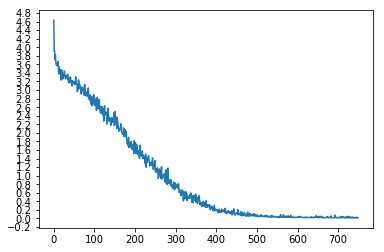

In [32]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, 1,
                               dropout_p=0.1)
trainEpochs(encoder1, attn_decoder1, 75000, print_every=5000)

In [33]:
evaluateRandomly(encoder1, attn_decoder1)

> 그녀는 정절의 화신이다 .
= she is chastity personified .
< she is chastity personified . <EOS>

> 그들은 의심과 공포에 의해 사로잡혔다 .
= they are beset by doubts and fears .
< they are beset by doubts and fears . <EOS>

> 나는 내가 거기에 없었다는 것이 매우 다행스럽다 .
= i m very glad i wasn t there .
< i m very glad i wasn t there . <EOS>

> 그는 정치에 대해서는 문외한이다 .
= he is a layman in politics .
< he is a layman in politics . <EOS>

> 나는 별로 피곤하지 않다 .
= i m not overly tired .
< i m not overly tired . <EOS>

> 그는 죄인일 따름이다 .
= he is nothing but a criminal .
< he is nothing but a criminal . <EOS>

> 나는 결과에 대해 당혹감을 느낀다 .
= i am perplexed at the result .
< i am perplexed at the result . <EOS>

> 우리는 어디로 여행해야 하는지를 고려하고 있다 .
= we are contemplating where we should travel to .
< we are contemplating where we should travel to . <EOS>

> 그는 너만큼 크다 .
= he is as tall as you .
< he

In [45]:
evaluate(encoder1, attn_decoder1, "나는 문외한이다 .")

(['i', 'm', 'thirty', '.', '<EOS>'], 
 
 Columns 0 to 5 
  9.9993e-01  1.4515e-05  1.6871e-07  3.1713e-05  8.3107e-06  7.1588e-08
  6.8301e-06  9.9997e-01  4.5148e-08  1.7585e-05  1.4182e-06  3.5381e-07
  3.7049e-08  5.1819e-09  5.7991e-10  1.0000e+00  2.3891e-09  7.3803e-08
  1.4249e-03  1.0239e-05  9.9482e-01  1.9597e-06  2.5249e-04  7.0925e-05
  2.4983e-03  4.2837e-05  2.3602e-03  3.3387e-03  1.4736e-07  1.9626e-08
 
 Columns 6 to 9 
  1.1412e-06  2.0216e-06  3.6516e-06  6.7844e-06
  2.7258e-07  5.2105e-07  2.2808e-07  5.9009e-07
  1.5971e-07  3.5228e-08  1.8237e-08  8.9589e-09
  1.6057e-03  1.3986e-04  4.4840e-04  1.2240e-03
  2.4678e-03  1.0669e-01  6.6073e-02  8.1653e-01
 [torch.FloatTensor of size 5x10])